In [1]:
from make_prediction import DataSplits

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import seaborn as sns
sns.set()

In [4]:
data = pd.read_pickle("predictions.pkl")

In [5]:
import weighted_ks

In [6]:
import concurrent.futures
import multiprocessing

In [10]:
def distance(sample1, sample2, w1, w2, n_iterations=100):
    assert len(sample1) == len(w1)
    assert len(sample2) == len(w2)
    assert w1.ndim == w2.ndim == 1
    assert sample1.ndim == sample2.ndim == 2
    assert sample1.shape[1] == sample2.shape[1]

    def single_iteration_(dummy):
        del dummy
        direction = np.random.normal(size=(1, sample1.shape[1]))
        return weighted_ks.ks_2samp_w(
                         (sample1 * direction).sum(axis=1),
                         (sample2 * direction).sum(axis=1),
                         w1, w2
                     )
    with concurrent.futures.ThreadPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
        result = max(executor.map(single_iteration_, range(n_iterations)))

    return result

In [7]:
import utils_rich_mrartemev as utils_rich

In [8]:
X_cols = utils_rich.raw_feature_columns
Y_cols = utils_rich.dll_columns
w_col  = utils_rich.weight_col
pred_cols = ["predicted_{}".format(col) for col in Y_cols]

In [9]:
from tqdm import tqdm_notebook as tqdm
from itertools import combinations

Calculating random-slice distances between various samples *(not very informative and **quite computationally heavy**)*:

In [ ]:
distances = dict()
for particle, df in data.items():
    all_dfs = dict(
        real_train=(df.train[X_cols + Y_cols], df.train[w_col]),
        real_val  =(df.val  [X_cols + Y_cols], df.val  [w_col]),
        real_test =(df.test [X_cols + Y_cols], df.test [w_col]),
        gen_train=(df.train[X_cols + pred_cols], df.train[w_col]),
        gen_val  =(df.val  [X_cols + pred_cols], df.val  [w_col]),
        gen_test =(df.test [X_cols + pred_cols], df.test [w_col])
    )
    print(particle)
    distances[particle] = {
        (s1, s2) : distance(df1.values, df2.values, w1.values, w2.values)
        for (s1, (df1, w1)), (s2, (df2, w2)) in tqdm(combinations(all_dfs.items(), 2))
    }
    for k, v in distances[particle].items():
        print(k, v)

pd.to_pickle(distances, 'distances.pkl')

In [11]:
import time

In [28]:
def get_percentile_range(array, weights, percentile, min_sumw=100):
    if weights.sum() < min_sumw:
        return array.min(), array.max()
    ix = np.argsort(array)
    array, weights = array[ix], weights[ix]
    cdf = weights.cumsum()
    cdf /= cdf[-1]
    i_left_rev = np.argmax(cdf[::-1] < percentile)
    i_right = np.argmax(cdf > 1. - percentile)
    left = array[::-1][i_left_rev]
    right = array[i_right]
    return left, right

def get_range(weights, *arrays, percentile=0.01):
    lefts, rights = zip(
        *[get_percentile_range(arr, weights, percentile) for arr in arrays]
    )
    return min(lefts), max(rights)

def plot_hist_real_vs_gen(df, col, ax=None, selection=None, n_bins=None, linear=True):
    predicted_col = "predicted_{}".format(col)

    if selection is not None:
        df = df[selection]
    
    real = df[col].values
    gen  = df[predicted_col].values
    w = df[utils_rich.weight_col].values

    if n_bins is None:
        n_bins = max(np.floor(w.sum()**0.5 / 4).astype(int), 4)
    
    bins = np.linspace(
        *get_range(w, real, gen, percentile=0.01 if linear else 0.),
        n_bins + 1
    )
    
    if ax is None:
        fig, ax = plt.subplots()

    ax.hist(real, weights=w, bins=bins, label='real')
    ax.hist(gen , weights=w, bins=bins, label='gen', alpha=0.5)
    if not linear:
        ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel(col)

In [13]:
from itertools import product

def make_bins_selection(df, bins_dict, cols=None):
    if cols is None:
        cols = [col for col in bins_dict.keys()]
    
    features = df[cols].values
    
    bins_nd = [bins_dict[col] for col in cols]
    bins_left  = [[l for l in bins[:-1]] for bins in bins_nd]
    bins_right = [[r for r in bins[1: ]] for bins in bins_nd]

    shape = [len(bins) - 1 for bins in bins_nd]
    shape.append(len(df))
    
    selection = np.array(
        [(features >= lefts).all(axis=1) & (features <= rights).all(axis=1)
         for lefts, rights in zip(product(*bins_left), product(*bins_right))]
    )
    selection_labels = np.array(
        [['{:.3} <= {} <= {:.3}'.format(l, name, r) for name, l, r in zip(cols, lefts, rights)]
         for lefts, rights in zip(product(*bins_left), product(*bins_right))]
    )
    selection_labels = selection_labels.reshape(*shape[:-1], -1)
    selection = selection.reshape(shape)
    return selection, selection_labels

In [14]:
def get_quantiles(arr, w, n):
    ix = np.argsort(arr)
    arr, w = arr[ix], w[ix]
    cdf = w.cumsum()
    cdf /= cdf[-1]
    thresholds = np.arange(n + 1, dtype=float) / n
    ids = np.argmax(cdf[:,np.newaxis] >= thresholds[np.newaxis,:], axis=0)
    return arr[ids]

In [19]:
def plot_in_bins_2d(function, selection, labels,
                    figsize=(15, 10),
                    min_samples=50,
                    fontsize=15,
                    **params):
    assert selection.ndim == 3
    
    fig, axxx = plt.subplots(selection.shape[0], selection.shape[1], figsize=figsize)
    
    for i_row, axx in enumerate(axxx):
        for i_col, ax in enumerate(axx):
            sel = selection[i_row, i_col]
            if sel.sum() > min_samples:
                function(**params, ax=ax, selection=sel)
                ax.text(0.5, 1.0, labels[i_row][i_col][1],
                        bbox={'facecolor':'white', 'pad':3},
                        transform=ax.transAxes,
                        horizontalalignment='center',
                        fontsize=fontsize)
                
                ax.text(0.0, 0.5, labels[i_row][i_col][0],
                        bbox={'facecolor':'white', 'pad':3},
                        transform=ax.transAxes,
                        verticalalignment='center',
                        rotation='vertical',
                        fontsize=fontsize)
            else:
                ax.axis('off')
    fig.tight_layout()
    return fig

In [17]:
plt.rcParams["patch.force_edgecolor"] = False

In [26]:
import os

output_dir = 'pdfs'

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

In [23]:
data.keys()

dict_keys(['kaon', 'pion', 'proton', 'muon'])

In [ ]:
particles = ['pion', 'kaon', 'proton', 'muon']
variables = ['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']
bin_cols = ['Brunel_P', 'Brunel_ETA']
nbins = [8, 8]

for particle in particles:
    print("Working on:", particle)
    df = data[particle].test

    bins_dict = {col : get_quantiles(df[col].values,
                                     df[utils_rich.weight_col].values,
                                     n)
                 for col, n in zip(bin_cols, nbins)}

    selection, labels = make_bins_selection(df, bins_dict, bin_cols)
    
    for variable in tqdm(variables):
        fig = plot_in_bins_2d(plot_hist_real_vs_gen,
                              selection[::-1],
                              labels[::-1],
                              figsize=(45, 45), df=df, col=variable)
        file_name = "{particle}_{target}_in_{y}_vs_{x}.pdf".format(
            particle=particle, target=variable,
            y=bin_cols[0], x=bin_cols[1]
        )
        fig.savefig(os.path.join(output_dir, file_name))

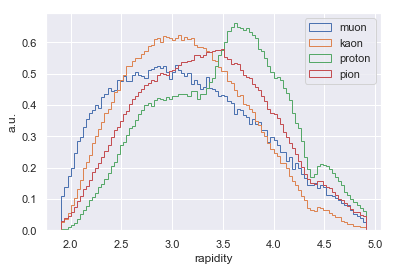

In [99]:
l1, r1 = get_percentile_range(data['muon'  ].test.Brunel_ETA.values, data['muon'  ].test.probe_sWeight.values, percentile=0.01)
l2, r2 = get_percentile_range(data['kaon'  ].test.Brunel_ETA.values, data['kaon'  ].test.probe_sWeight.values, percentile=0.01)
l3, r3 = get_percentile_range(data['proton'].test.Brunel_ETA.values, data['proton'].test.probe_sWeight.values, percentile=0.01)
l4, r4 = get_percentile_range(data['pion'  ].test.Brunel_ETA.values, data['pion'  ].test.probe_sWeight.values, percentile=0.01)

bins = np.linspace(min(l1, l2, l3, l4), max(r1, r2, r3, r4), 100)
plt.hist(data['muon'  ].test.Brunel_ETA, weights=data['muon'  ].test.probe_sWeight, label='muon'  , bins=bins, density=True, histtype='step')
plt.hist(data['kaon'  ].test.Brunel_ETA, weights=data['kaon'  ].test.probe_sWeight, label='kaon'  , bins=bins, density=True, histtype='step')
plt.hist(data['proton'].test.Brunel_ETA, weights=data['proton'].test.probe_sWeight, label='proton', bins=bins, density=True, histtype='step')
plt.hist(data['pion'  ].test.Brunel_ETA, weights=data['pion'  ].test.probe_sWeight, label='pion'  , bins=bins, density=True, histtype='step')
plt.legend()
plt.xlabel('rapidity')
plt.ylabel('a.u.')

file_name = "ETA.pdf"
plt.savefig(os.path.join(output_dir, file_name))

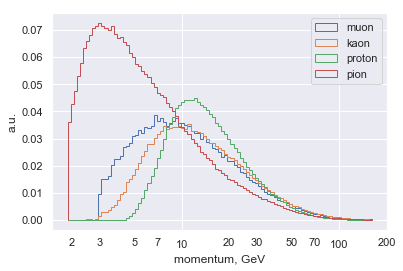

In [100]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, LogLocator


l1, r1 = get_percentile_range(data['muon'  ].test.Brunel_P.values / 1000, data['muon'  ].test.probe_sWeight.values, percentile=0.01)
l2, r2 = get_percentile_range(data['kaon'  ].test.Brunel_P.values / 1000, data['kaon'  ].test.probe_sWeight.values, percentile=0.01)
l3, r3 = get_percentile_range(data['proton'].test.Brunel_P.values / 1000, data['proton'].test.probe_sWeight.values, percentile=0.01)
l4, r4 = get_percentile_range(data['pion'  ].test.Brunel_P.values / 1000, data['pion'  ].test.probe_sWeight.values, percentile=0.01)
l = min(l1, l2, l3, l4)
r = max(r1, r2, r3, r4)
bins = np.logspace(np.log10(l), np.log10(r), 100)
plt.hist(data['muon'  ].test.Brunel_P / 1000, weights=data['muon'  ].test.probe_sWeight, label='muon'  , bins=bins, density=True, histtype='step')
plt.hist(data['kaon'  ].test.Brunel_P / 1000, weights=data['kaon'  ].test.probe_sWeight, label='kaon'  , bins=bins, density=True, histtype='step')
plt.hist(data['proton'].test.Brunel_P / 1000, weights=data['proton'].test.probe_sWeight, label='proton', bins=bins, density=True, histtype='step')
plt.hist(data['pion'  ].test.Brunel_P / 1000, weights=data['pion'  ].test.probe_sWeight, label='pion'  , bins=bins, density=True, histtype='step')
plt.legend()
plt.xscale('log')
plt.xlabel('momentum, GeV')
plt.ylabel('a.u.')
plt.gca().get_xaxis().set_minor_formatter(ScalarFormatter())
plt.gca().get_xaxis().set_minor_locator(LogLocator(subs=[2,3,5,7]))
plt.gca().get_xaxis().set_major_formatter(ScalarFormatter())

file_name = "P.pdf"
plt.savefig(os.path.join(output_dir, file_name))

In [111]:
def make_n_sample_bins(samples, weights, n):
    edges = np.array([get_percentile_range(s, w, percentile=0.001)
                      for s, w in zip(samples, weights)])
    l, r = edges[:,0].max(), edges[:,1].min()
    selection = (samples[0] >= l) & (samples[0] <= r)
    return get_quantiles(samples[0][selection], weights[0][selection], n)

In [178]:
from my_roc_auc import my_roc_auc

def my_delta_roc_auc_bootstrap(classes, predictions_1, predictions_2, weights, n_bootstrap=100):
    result = np.empty(shape=n_bootstrap, dtype=float)
    for i in range(n_bootstrap):
        ids = np.random.randint(0, len(classes), len(classes))
        auc_1 = my_roc_auc(classes[ids], predictions_1[ids], weights[ids])
        auc_2 = my_roc_auc(classes[ids], predictions_2[ids], weights[ids])
        result[i] = auc_1 - auc_2
    return result

In [191]:
def get_aucs_in_bins(particles, signal_particle, variable, bin_cols, nbins, n_bootstrap=100):
    predicted_variable = 'predicted_{}'.format(variable)
    bins_dict = {col : make_n_sample_bins([data[p].test[col].values for p in particles],
                                          [data[p].test[utils_rich.weight_col].values for p in particles], n)
                 for col, n in zip(bin_cols, nbins)}
    cols = bin_cols + [variable, predicted_variable, utils_rich.weight_col]
    
    signal_sample = data[signal_particle].test[cols].copy()
    signal_sample['signal'] = 1
    bg_sample = pd.concat([data[p].test[cols] for p in particles if p != signal_particle], axis=0).copy()
    bg_sample['signal'] = 0
    
    sample = pd.concat([signal_sample, bg_sample], axis=0).reset_index(drop=True)
    selection, labels = make_bins_selection(sample, bins_dict, bin_cols)
    
    assert selection.ndim == 3
    
    aucs_real = np.empty(shape=selection.shape[:-1], dtype=float)
    aucs_gen  = np.empty(shape=selection.shape[:-1], dtype=float)
    delta_auc_error = np.empty(shape=selection.shape[:-1], dtype=float)
    for i_row in tqdm(range(selection.shape[0])):
        for i_col in range(selection.shape[1]):
            current_sample = sample[selection[i_row, i_col]]
            aucs_real[i_row, i_col] = my_roc_auc(current_sample['signal'].values,
                                                 current_sample[variable].values,
                                                 current_sample[utils_rich.weight_col].values)
            aucs_gen [i_row, i_col] = my_roc_auc(current_sample['signal'].values,
                                                 current_sample[predicted_variable].values,
                                                 current_sample[utils_rich.weight_col].values)
            
            delta_auc_error[i_row, i_col] = my_delta_roc_auc_bootstrap(
                current_sample['signal'].values,
                current_sample[predicted_variable].values,
                current_sample[variable].values,
                current_sample[utils_rich.weight_col].values,
                n_bootstrap=n_bootstrap
            ).std()
    
    return aucs_real, aucs_gen, delta_auc_error, bins_dict

In [208]:
def plot_delta_auc_heatmap(
            particles,
            signal_particle,
            variable,
            bin_cols,
            nbins, title, n_bootstrap=20
        ):
    aucs_real, aucs_gen, delta_auc_error, bins_dict = get_aucs_in_bins(
        particles, signal_particle, variable, bin_cols, nbins, n_bootstrap=n_bootstrap
    )

    diff = abs(aucs_gen - aucs_real) / delta_auc_error
    l, r = diff.min(), diff.max()
    ticks = [0.0001, 0.001, 0.01, 0.1]
    sns.heatmap(diff, cmap='RdPu',
                annot=True);
    bins = [bins_dict[col] / 1000 if col == 'Brunel_P' else bins_dict[col]
            for col in bin_cols]
    labels = ['momentum, GeV' if col == 'Brunel_P' else
              'rapidity' if col == 'Brunel_ETA' else col
              for col in bin_cols]
    plt.yticks(range(len(bins_dict[bin_cols[0]]) + 1), np.round(bins[0], 1));
    plt.xticks(range(len(bins_dict[bin_cols[1]]) + 1), np.round(bins[1], 1));
    plt.ylabel(labels[0])
    plt.xlabel(labels[1])
    plt.title(title, fontsize=12)
    plt.ylim(0, len(bins_dict[bin_cols[0]]) - 1);
    plt.xlim(0, len(bins_dict[bin_cols[1]]) - 1);

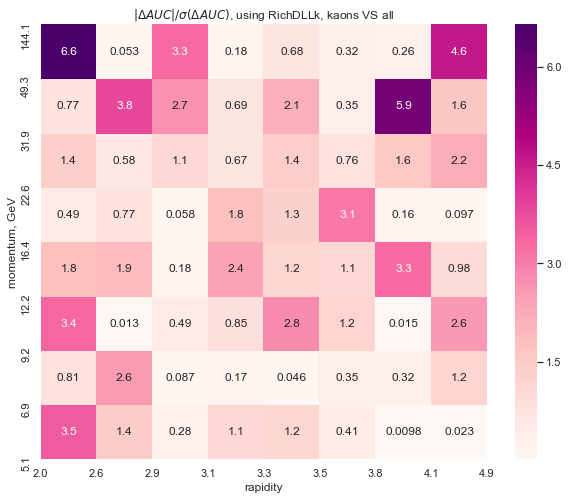

In [210]:
particles = ['pion', 'kaon', 'proton', 'muon']
signal_particle = 'kaon'
variable = 'RichDLLk'
bin_cols = ['Brunel_P', 'Brunel_ETA']
nbins = [8, 8]

plt.figure(figsize=(10, 8))
plot_delta_auc_heatmap(particles, signal_particle, variable, bin_cols, nbins, 
                       title=r"$|\Delta AUC| / \sigma(\Delta AUC)$, using RichDLLk, kaons VS all",
                       n_bootstrap=50)

file_name = "DeltaAUC_{variable}_{signal_particle}_vs_all.pdf".format(
    variable=variable, signal_particle=signal_particle, 
)
plt.savefig(os.path.join(output_dir, file_name))

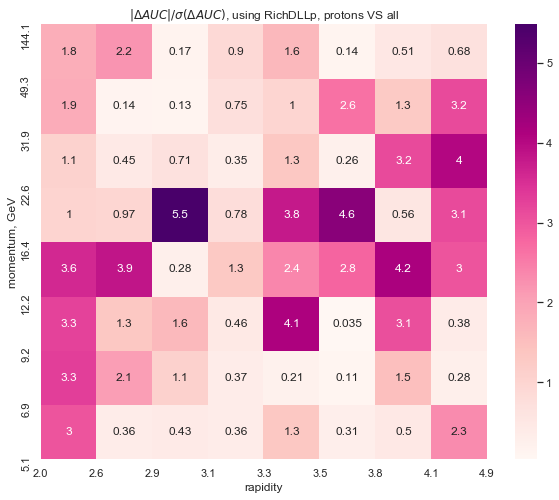

In [212]:
particles = ['pion', 'kaon', 'proton', 'muon']
signal_particle = 'proton'
variable = 'RichDLLp'
bin_cols = ['Brunel_P', 'Brunel_ETA']
nbins = [8, 8]

plt.figure(figsize=(10, 8))
plot_delta_auc_heatmap(particles, signal_particle, variable, bin_cols, nbins, 
                       title=r"$|\Delta AUC| / \sigma(\Delta AUC)$, using {}, {}s VS all".format(
                           variable, signal_particle),
                       n_bootstrap=50)

file_name = "DeltaAUC_{variable}_{signal_particle}_vs_all.pdf".format(
    variable=variable, signal_particle=signal_particle,
)
plt.savefig(os.path.join(output_dir, file_name))

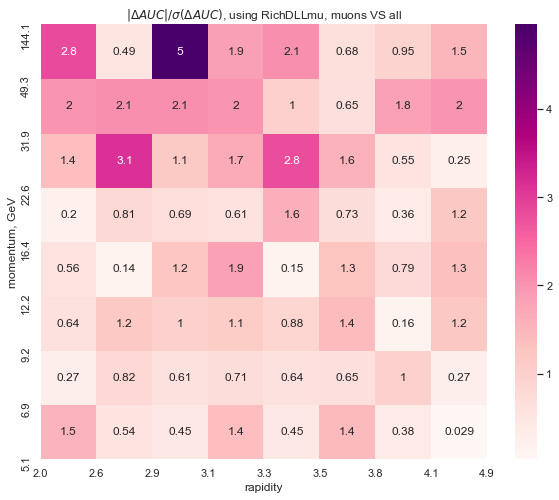

In [213]:
particles = ['pion', 'kaon', 'proton', 'muon']
signal_particle = 'muon'
variable = 'RichDLLmu'
bin_cols = ['Brunel_P', 'Brunel_ETA']
nbins = [8, 8]

plt.figure(figsize=(10, 8))
plot_delta_auc_heatmap(particles, signal_particle, variable, bin_cols, nbins, 
                       title=r"$|\Delta AUC| / \sigma(\Delta AUC)$, using {}, {}s VS all".format(
                           variable, signal_particle),
                       n_bootstrap=50)

file_name = "DeltaAUC_{variable}_{signal_particle}_vs_all.pdf".format(
    variable=variable, signal_particle=signal_particle,
)
plt.savefig(os.path.join(output_dir, file_name))